<a href="https://www.kaggle.com/code/mohamedelbadri01/sf-plot-scores?scriptVersionId=207365499" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [27]:
# !pip install numpy pandas xarray xskillscore
# !pip install cdsapi
# !pip install matplotlib cartopy
# !pip install cfgrib
# !pip install ipywidgets
# !pip install seaborn

In [28]:
import os

import calendar

import xarray as xr

import ipywidgets as widgets

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import cartopy.feature as cfeature

import numpy as np

import seaborn as sns

# widgets.IntSlider()

# %matplotlib widget

import warnings

warnings.filterwarnings('ignore')

# Configure the path and settings

SCOREDIR = "/kaggle/input/scores"

config = dict(

    list_vars = ['2m_temperature', ],

    hcstarty = 1993,

    hcendy = 2016,

    start_month = 11,

)



details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"



available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]





VARNAMES = {'t2m': '2-metre temperature'}

A-DETERLINISTIC

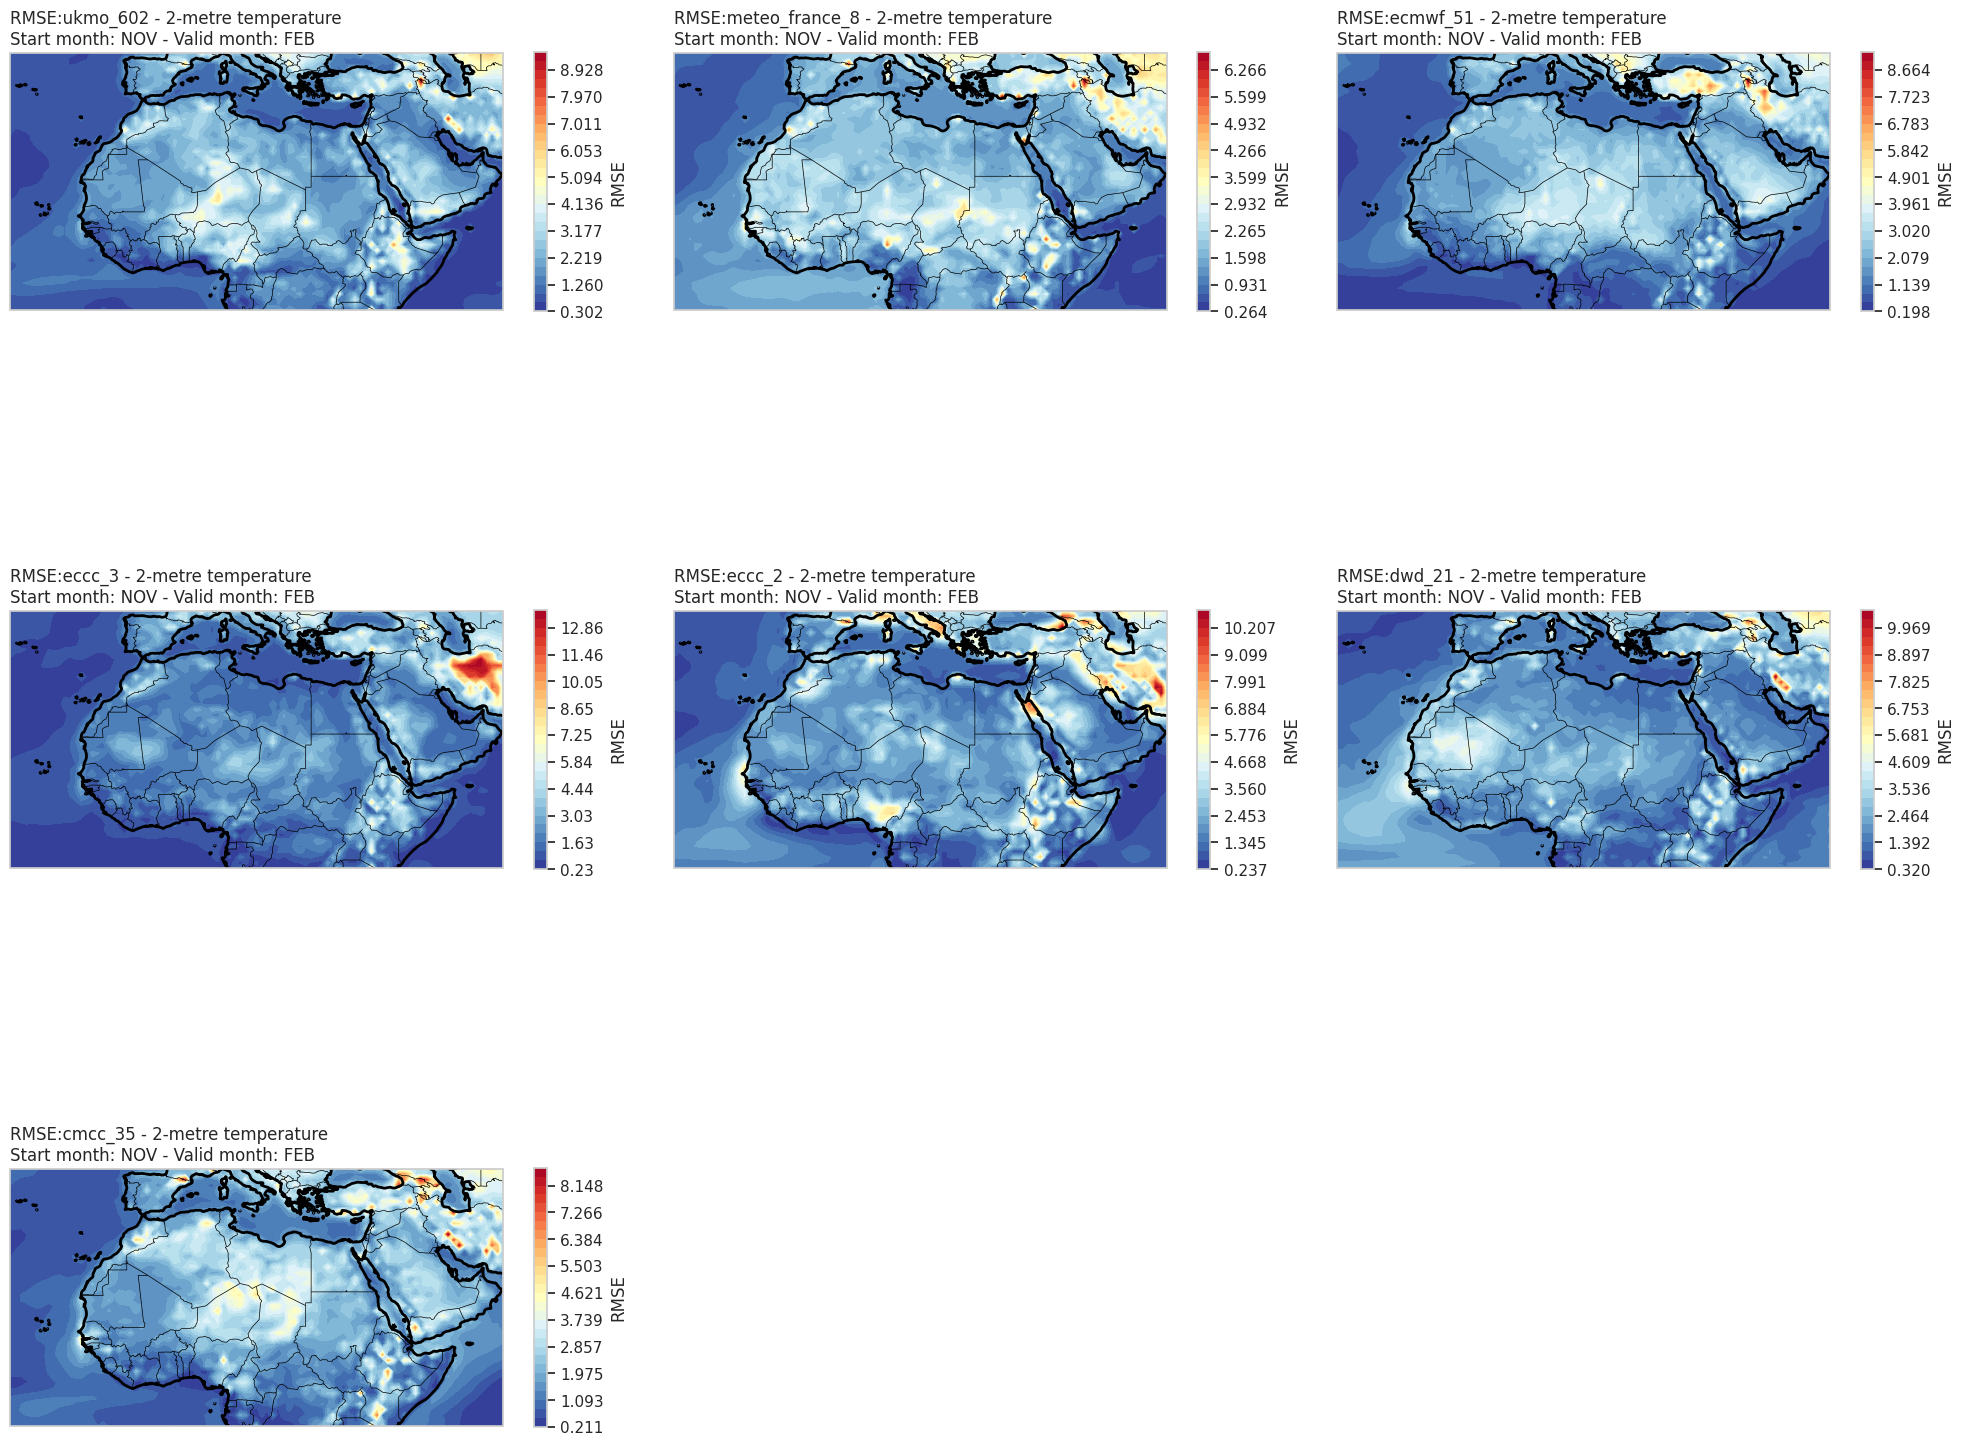

In [29]:


# Set constants
# SCOREDIR = "/home/mohamed/EHTPIII/MODELISATION/output/SF/"
config = dict(list_vars=['2m_temperature'], hcstarty=1993, hcendy=2016, start_month=11)
details = "_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"
available_files = ["ukmo_602", "meteo_france_8", "ecmwf_51", "eccc_3", "eccc_2", "dwd_21", "cmcc_35"]
VARNAMES = {'t2m': '2-metre temperature'}
metrics = ["corr", "rsquared", "rmse"]

# Load the datasets based on selected file, aggregation, and metric
def load_data(file_name, aggr, metric):
    file_link = f'{SCOREDIR}/{file_name}{details}.{aggr}.{metric}.nc'
    corr = xr.open_dataset(file_link)
    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')
    return corr

# Define the plot function with 3 columns layout
def plot_all_centers(aggr, fcmonth, metric):
    n_files = len(available_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, (ax, file_name) in enumerate(zip(axes, available_files)):
        origin_labels = {'institution': file_name, 'metric': metric}
        METR = load_data(file_name, aggr, metric)
        tit_line1 = f"{metric.upper()}:{file_name}"
        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

        # Determine the valid month(s) for title
        if aggr == '1m':
            validmonth = config['start_month'] + (fcmonth - 1)
            validmonth = validmonth if validmonth <= 12 else validmonth - 12
            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
        elif aggr == '3m':
            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]
            tit_line2 = tit_line2_base + f' - Valid months: {" ".join(reversed(validmonths))}'
        else:
            raise ValueError(f'Unexpected aggregation {aggr}')

        # Select data for the chosen forecast month
        THISMETR = METR.sel(forecastMonth=fcmonth)

        # Plot each variable for this center
        for var in THISMETR.data_vars:
            METRVALUES = THISMETR[var].values
            if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):
                METRVALUES = METRVALUES.T

            im = ax.contourf(
                THISMETR[var].lon, THISMETR[var].lat, METRVALUES,
                levels=np.linspace(np.nanmin(METRVALUES), np.nanmax(METRVALUES), 30),
                cmap='RdYlBu_r'
            )

            cb = fig.colorbar(im, ax=ax, shrink=0.4)
            cb.ax.set_ylabel(metric.upper(), fontsize=12)

            ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.0)
            ax.set_title(f"{tit_line1} - {VARNAMES.get(var, var)}\n{tit_line2}", loc='left')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Create interactive widgets for `aggr`, `fcmonth`, and metric selection
aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')
metric_dropdown = widgets.Dropdown(options=metrics, value="rmse", description="Metric")

# Display the interactive plot
widgets.interactive(plot_all_centers, aggr=aggr_dropdown, fcmonth=fcmonth_slider, metric=metric_dropdown)

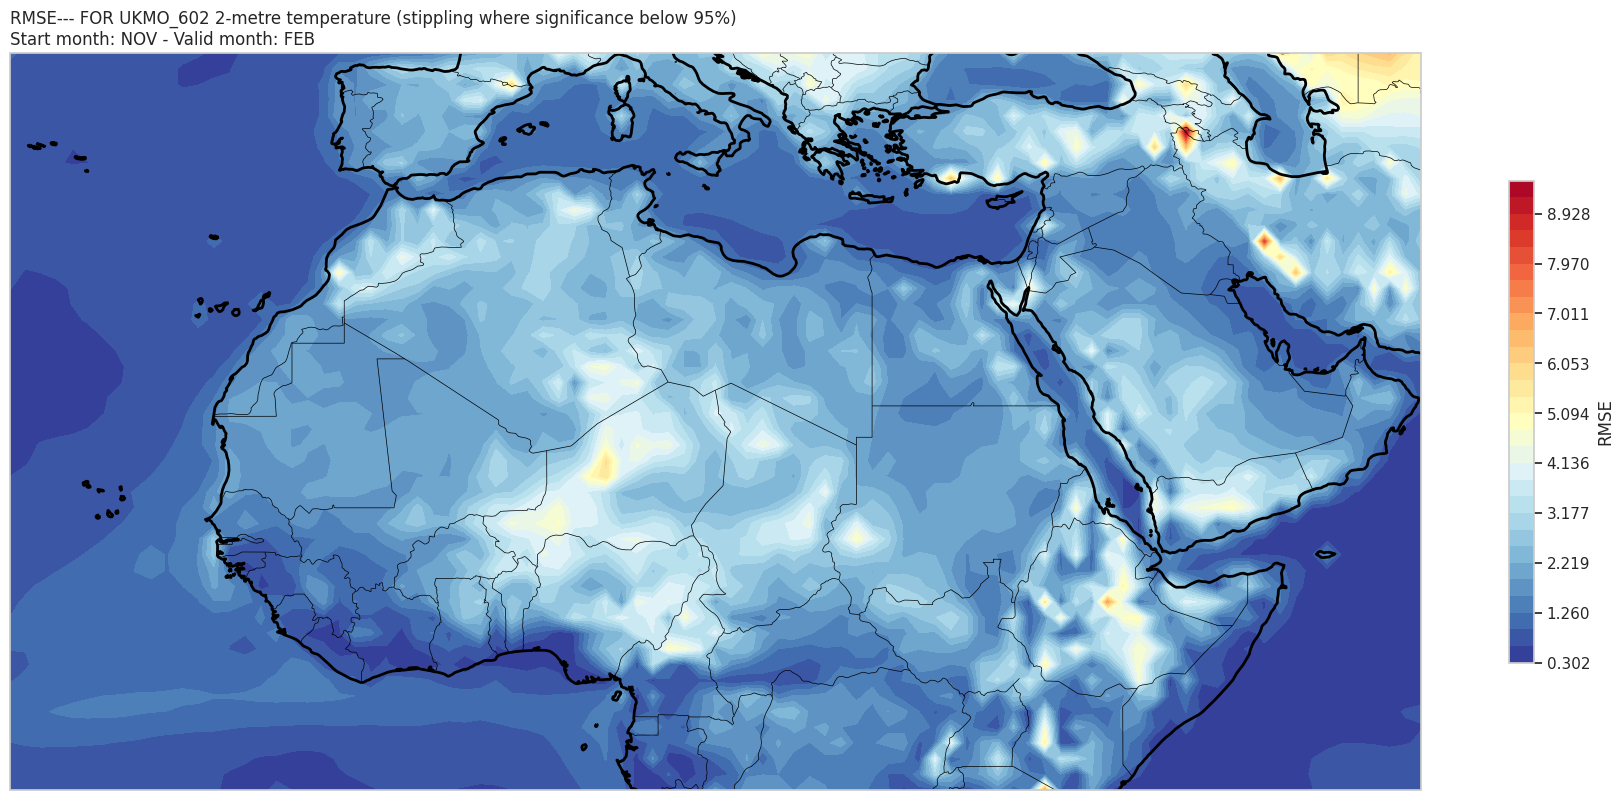

In [30]:


# Create dropdown widget for file selection

file_dropdown = widgets.Dropdown(

    options=available_files,

    description='CENTER'

)



# Load the datasets based on selected file and aggregation

def load_data(file_name, aggr,metric):

    file_link=f'{SCOREDIR}/{file_name}{details}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr

# Define the plot function

metrics=["corr","rsquared","rmse"]

def plot_corr(file_name, aggr, fcmonth,metric):

    origin_labels = {'institution': f'{file_name}'

                     ,'metric':f'{metric}'}

    METR = load_data(file_name, aggr,metric)

    tit_line1='{metric}---'.format(**origin_labels).upper()+" FOR "+file_name.upper()        

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

        tit_line2 = tit_line2_base + f' - Valid months: {" ".join(reversed(validmonths))}'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')



    # Select data for the chosen forecast month

    THISMETR = METR.sel(forecastMonth=fcmonth)



    for var in THISMETR.data_vars:

        fig = plt.figure(figsize=(18, 10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)

        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.0)

        METRVALUES = THISMETR[var].values



        if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

            METRVALUES = METRVALUES.T



        plt.contourf(

            THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

            levels=np.linspace(np.nanmin(METRVALUES), np.nanmax(METRVALUES), 30),

            cmap='RdYlBu_r'

        )

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel(metric.upper(), fontsize=12)

        origylim = ax.get_ylim()

        if ax.get_ylim() != origylim:

            ax.set_ylim(origylim)



        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')

        plt.tight_layout()

        plt.show()



# Create interactive widgets for `aggr`, `fcmonth`, and file selection

aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')

fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')

metric_droptown=widgets.Dropdown(options=metrics,value="rmse",description="Metric")

# Display the interactive plot

widgets.interactive(plot_corr, metric=metric_droptown,file_name=file_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

# B-PROBABILISTIC

In [31]:
VARNAMES = {
    't2m' : '2m-T'
}
details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"

available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]

CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']

# Change titles font size
plt.rc('axes', titlesize=20)

## B-1 RPS

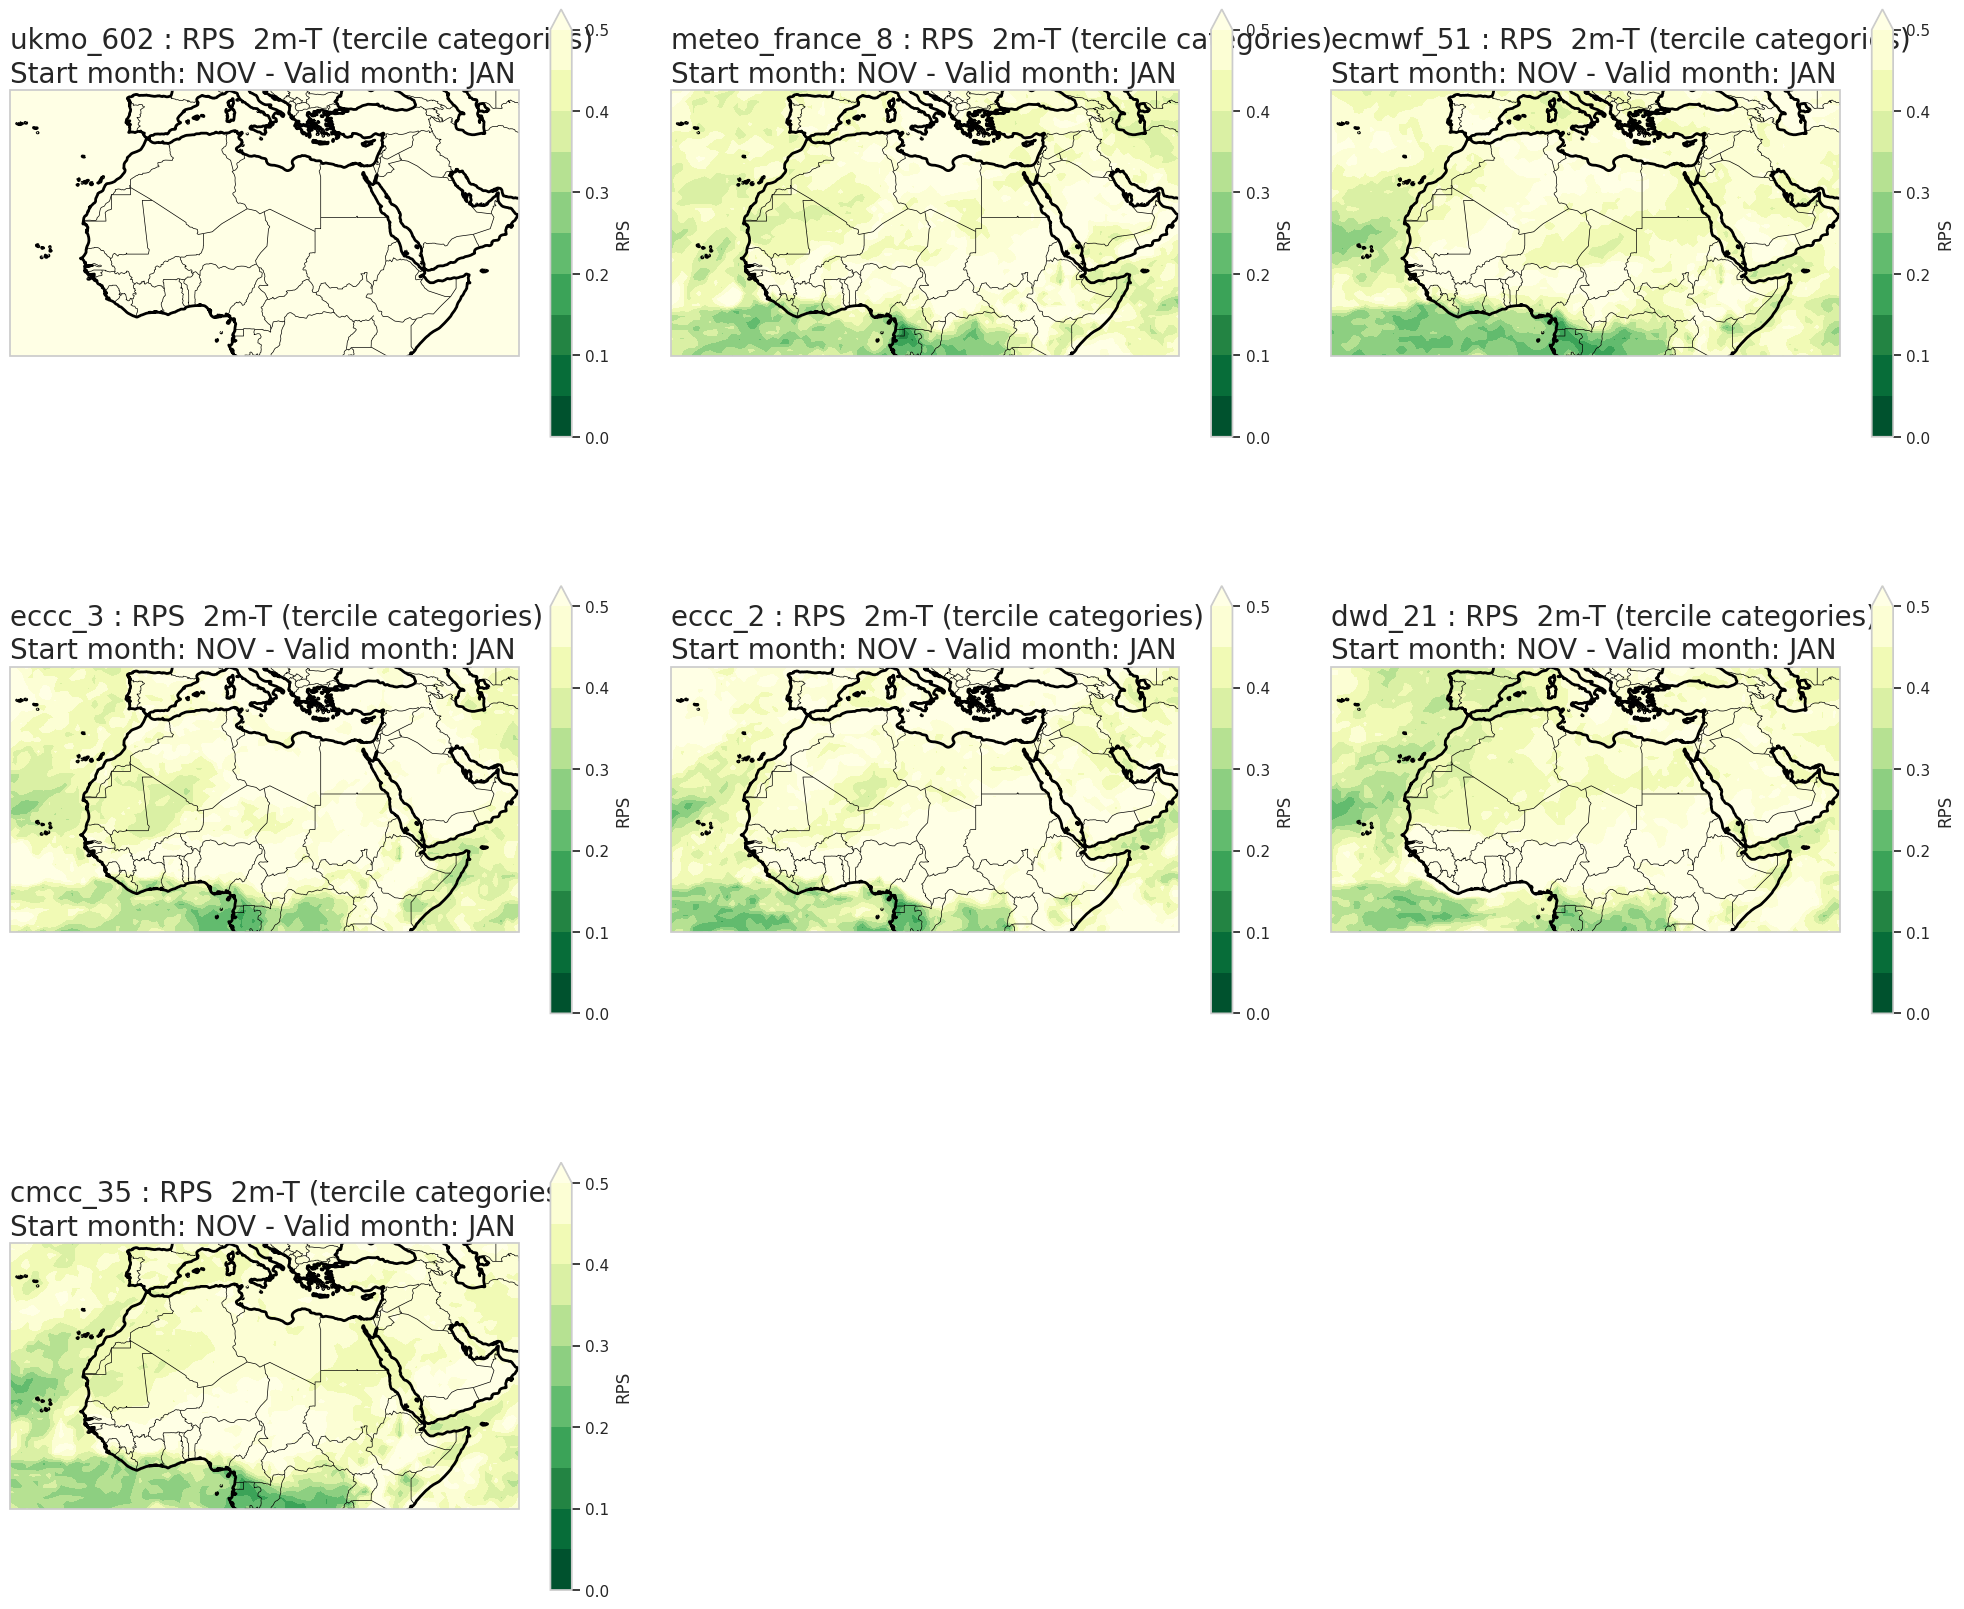

In [32]:
metric="rps"
def load_data(file,aggr,metric):
    rps = xr.open_dataset(f'{SCOREDIR}/{file}{details}.{aggr}.{metric}.nc')
    return rps

# Define the plot function
def plot_rps(aggr, fcmonth):
    n_files = len(available_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols 


    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    for i, center in enumerate(available_files):
        rps = load_data(center, aggr, "rps")
        origin_labels = {'institution': f'{center}',
                  'SCORE':"RPS"}
        # Select data for the chosen forecast month
        thisrps = rps.sel(forecastMonth=fcmonth)

        tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)
        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    
        if aggr=='1m':
            validmonth = config['start_month'] + (fcmonth-1)
            validmonth = validmonth if validmonth<=12 else validmonth-12
    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
        elif aggr=='3m':
            validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
            validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
            tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
        else:
            raise BaseException(f'Unexpected aggregation {aggr}')
        
        for var in thisrps.data_vars:
            ax = axes[i]
            ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
            ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
            
            # Plot the data
            avalues = thisrps[var].values
            cs = ax.contourf(thisrps[var].lon, thisrps[var].lat, avalues,
                             levels=np.linspace(0., 0.5, 11), cmap='YlGn_r', extend='max')
            cs.cmap.set_under('purple')
            
            # Add a colorbar to each subplot
            cb = fig.colorbar(cs, ax=ax, shrink=0.7)
            cb.ax.set_ylabel('RPS', fontsize=12)
            
            # Set the title for each subplot
            ax.set_title(tit_line1 + f' {VARNAMES.get(var, var)}' + ' (tercile categories)\n' + tit_line2, loc='left')
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Create interactive widgets for `aggr` and `fcmonth`
aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')
widgets.interactive(plot_rps, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

In [33]:
x=load_data("meteo_france_8","1m","rps")
x

<xarray.Dataset> Size: 106kB
Dimensions:        (lon: 91, lat: 48, forecastMonth: 3)
Coordinates:
  * lon            (lon) float64 728B -30.0 -29.0 -28.0 -27.0 ... 58.0 59.0 60.0
  * lat            (lat) float64 384B 44.5 43.5 42.5 41.5 ... 0.5 -0.5 -1.5 -2.5
  * forecastMonth  (forecastMonth) int32 12B 2 3 4
    surface        float64 8B ...
    start_month    int32 4B ...
    number         int32 4B ...
    step           timedelta64[ns] 8B ...
Data variables:
    t2m            (forecastMonth, lat, lon) float64 105kB ...

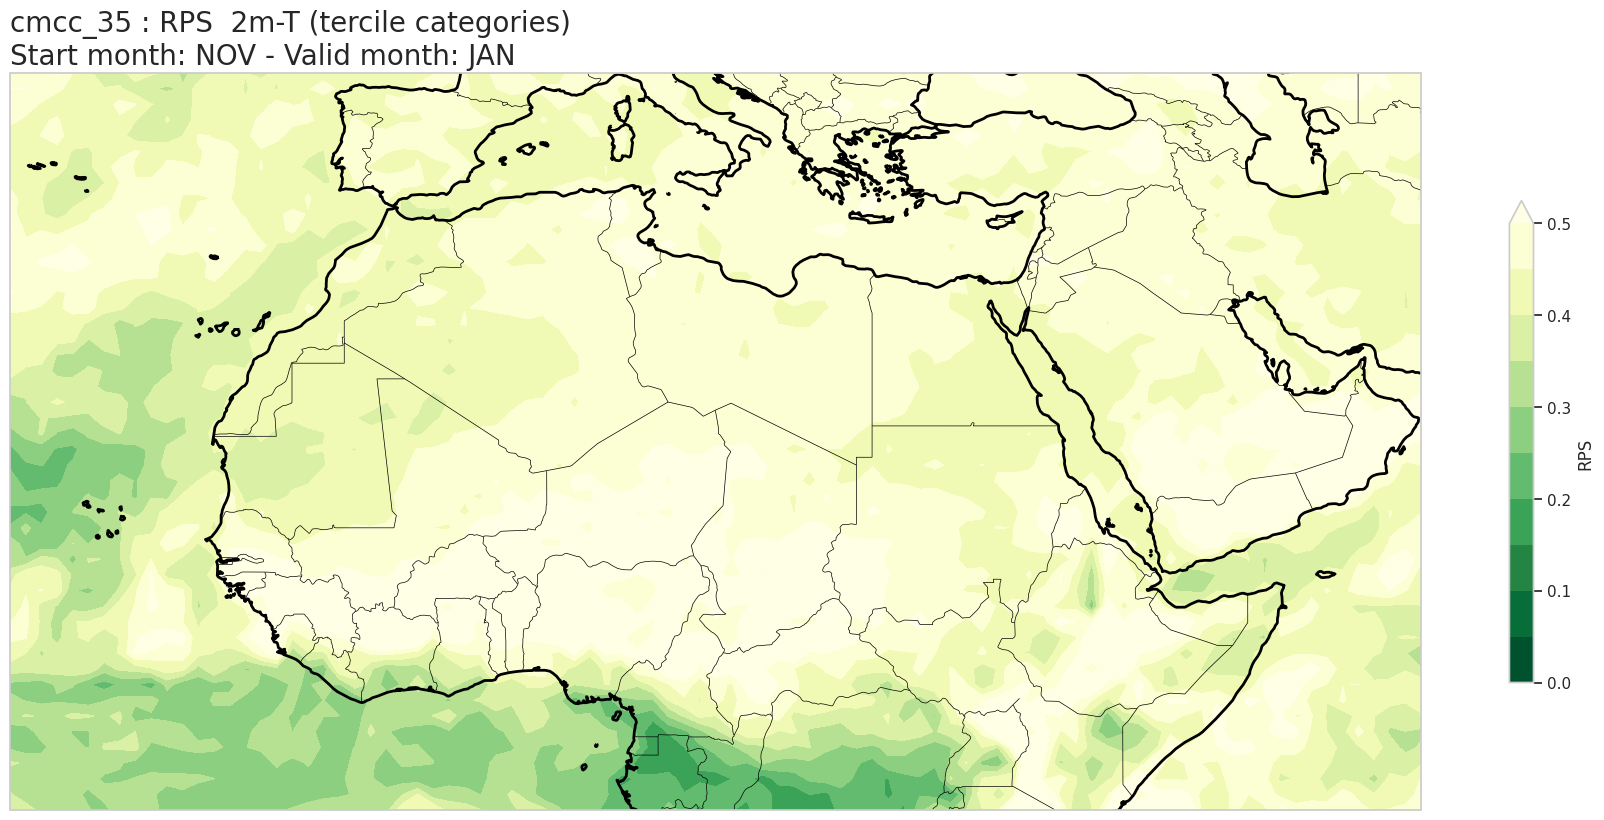

In [34]:
def load_data(file,aggr,metric):
    rps = xr.open_dataset(f'{SCOREDIR}/{file}{details}.{aggr}.{metric}.nc')
    return rps

# Define the plot function
def plot_corr(file,aggr, fcmonth):
    origin_labels = {'institution': f'{file}',
                    'SCORE':"RPS"}
    
    tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)
    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    
    if aggr=='1m':
        validmonth = config['start_month'] + (fcmonth-1)
        validmonth = validmonth if validmonth<=12 else validmonth-12
    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
    elif aggr=='3m':
        validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
        tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
    else:
        raise BaseException(f'Unexpected aggregation {aggr}')
    rps = load_data(file,aggr,"rps")
    
    # Select data for the chosen forecast month
    thisrps = rps.sel(forecastMonth=fcmonth)
    for var in thisrps.data_vars:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisrps[var].values
        cs = plt.contourf(thisrps[var].lon,thisrps[var].lat,avalues,levels=np.linspace(0.,0.5,11),cmap='YlGn_r', extend='max')
        cs.cmap.set_under('purple')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel('RPS',fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2,loc='left')
        plt.tight_layout()  
        plt.show()


# Create interactive widgets for `aggr` and `fcmonth`
aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')
file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")
widgets.interactive(plot_corr, file=file_droptown,aggr=aggr_dropdown, fcmonth=fcmonth_slider)

## B-2 ROC-ROCSS-BS

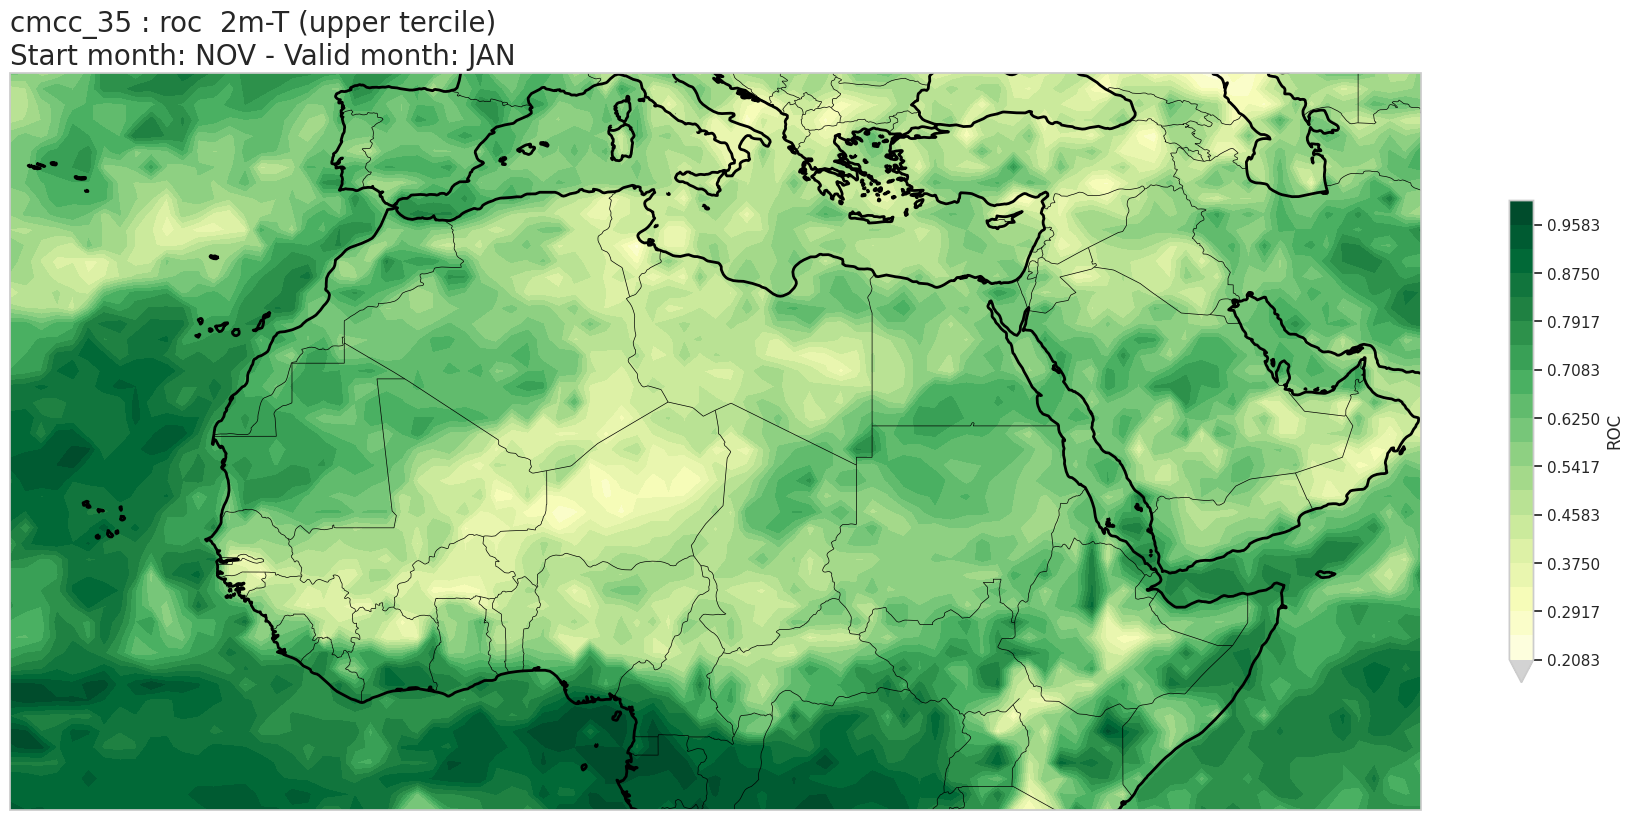

In [35]:
def load_data(file,aggr,metric):
    rps = xr.open_dataset(f'{SCOREDIR}/{file}{details}.{aggr}.{metric}.nc')
    return rps



def plot_roc(file,aggr,fcmonth,icat,metric):
    origin_labels = {'institution': f'{file}',
                    'SCORE':metric}
    
    tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)
    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    
    if aggr=='1m':
        validmonth = config['start_month'] + (fcmonth-1)
        validmonth = validmonth if validmonth<=12 else validmonth-12
    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
    elif aggr=='3m':
        validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
        tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
    else:
        raise BaseException(f'Unexpected aggregation {aggr}')
    
    roc=load_data(file,aggr,metric)
    thisroc = roc.sel(forecastMonth=fcmonth)
    for var in thisroc.data_vars:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisroc.sel(category=icat)[var].values
        cs = plt.contourf(thisroc[var].lon,thisroc[var].lat,avalues,levels=np.linspace(np.nanmin(avalues), np.nanmax(avalues), 20),cmap='YlGn', extend='min')
        cs.cmap.set_under('lightgray')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel(metric.upper(),fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')
        plt.tight_layout()  
        plt.show()

file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")
cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")
fcmonth_slider=widgets.IntSlider(value=3,min=2,max=4,step=1,description="fcmonth")
aggr_droptown=widgets.Dropdown(options=["1m","3m"],value="1m",description="aggr")
metric_dropdown=widgets.Dropdown(options=["roc","rocss","bs"],value="roc",description="Metric")
widgets.interactive(plot_roc,metric=metric_dropdown,file=file_droptown,aggr=aggr_droptown,fcmonth=fcmonth_slider,icat=cat_slider)

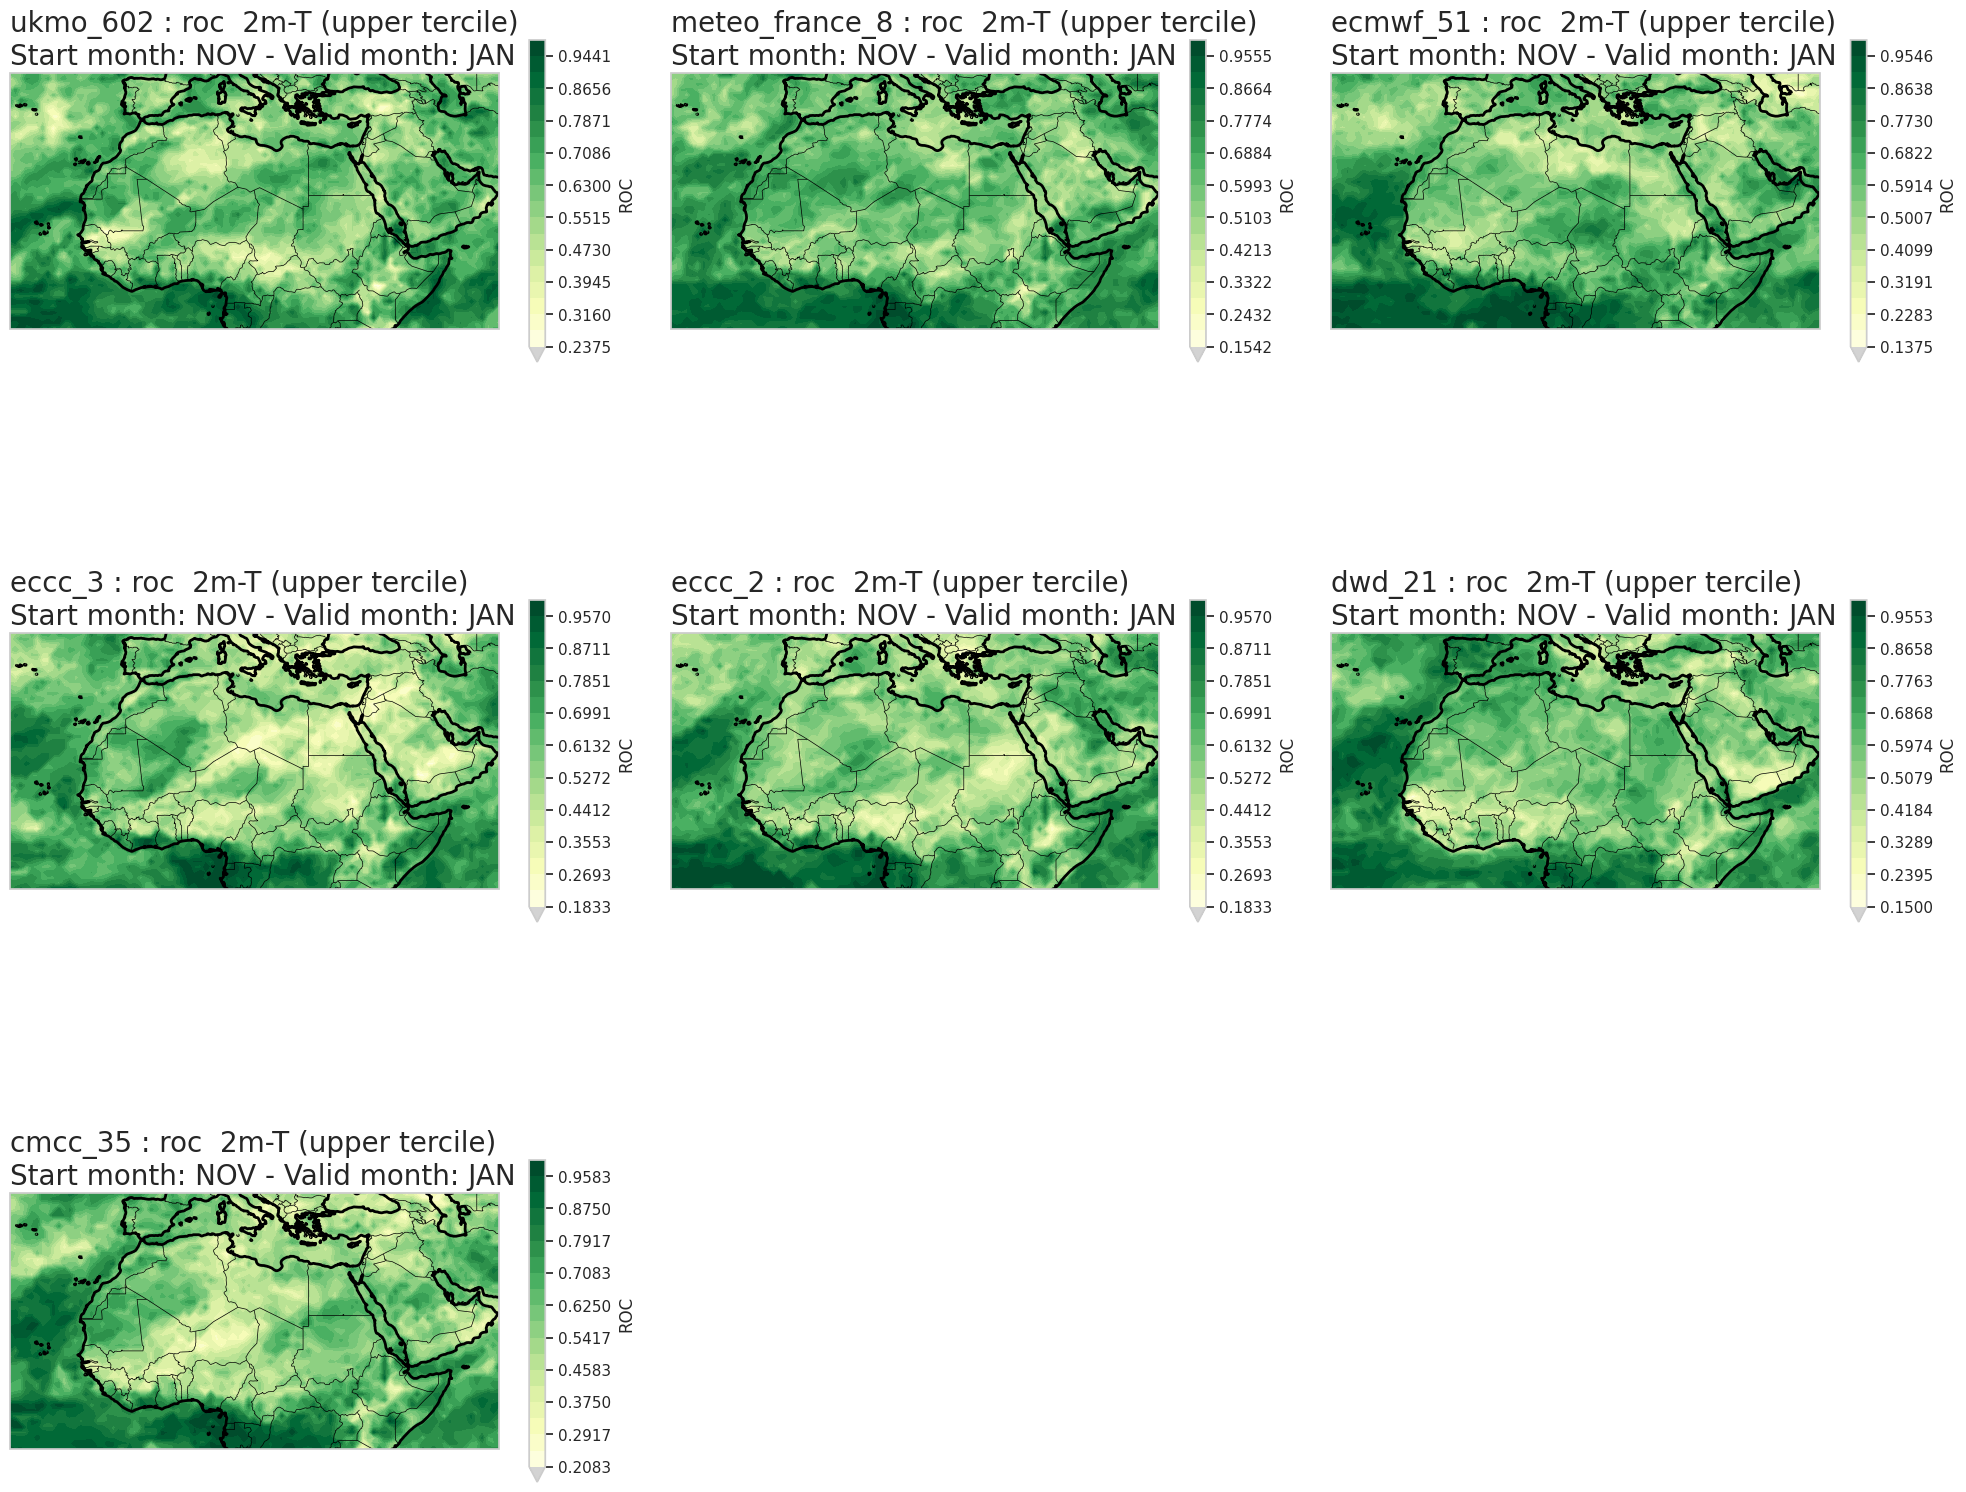

In [36]:
def plot_roc(aggr, fcmonth, icat, metric):
    n_files = len(available_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    for i in range(n_files):
        origin_labels = {'institution': f'{available_files[i]}', 'SCORE': metric}
        tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)
        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
        
        if aggr == '1m':
            validmonth = config['start_month'] + (fcmonth - 1)
            validmonth = validmonth if validmonth <= 12 else validmonth - 12
            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
        elif aggr == '3m':
            validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]
            validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
            tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
        else:
            raise BaseException(f'Unexpected aggregation {aggr}')

        roc = load_data(available_files[i], aggr, metric)
        thisroc = roc.sel(forecastMonth=fcmonth)

        for var in thisroc.data_vars:
            axes[i].add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
            axes[i].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.0)

            avalues = thisroc.sel(category=icat)[var].values

            if not np.isnan(avalues).all():
                cs = axes[i].contourf(
                    thisroc[var].lon,
                    thisroc[var].lat,
                    avalues,
                    levels=np.linspace(np.nanmin(avalues), np.nanmax(avalues), 20),
                    cmap='YlGn', 
                    extend='min'
                )
                cs.cmap.set_under('lightgray')
                cb = fig.colorbar(cs, ax=axes[i], shrink=0.5)
                cb.ax.set_ylabel(metric.upper(), fontsize=12)

            axes[i].set_title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')

    for j in range(n_files, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cat_slider = widgets.IntSlider(value=3, min=0, max=2, step=1, description="cat")
fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description="fcmonth")
aggr_dropdown = widgets.Dropdown(options=["1m", "3m"], value="1m", description="aggr")
metric_dropdown = widgets.Dropdown(options=["roc", "rocss", "bs"], value="roc", description="Metric")
widgets.interactive(plot_roc, metric=metric_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider, icat=cat_slider)

## B-3 RELIABILITY

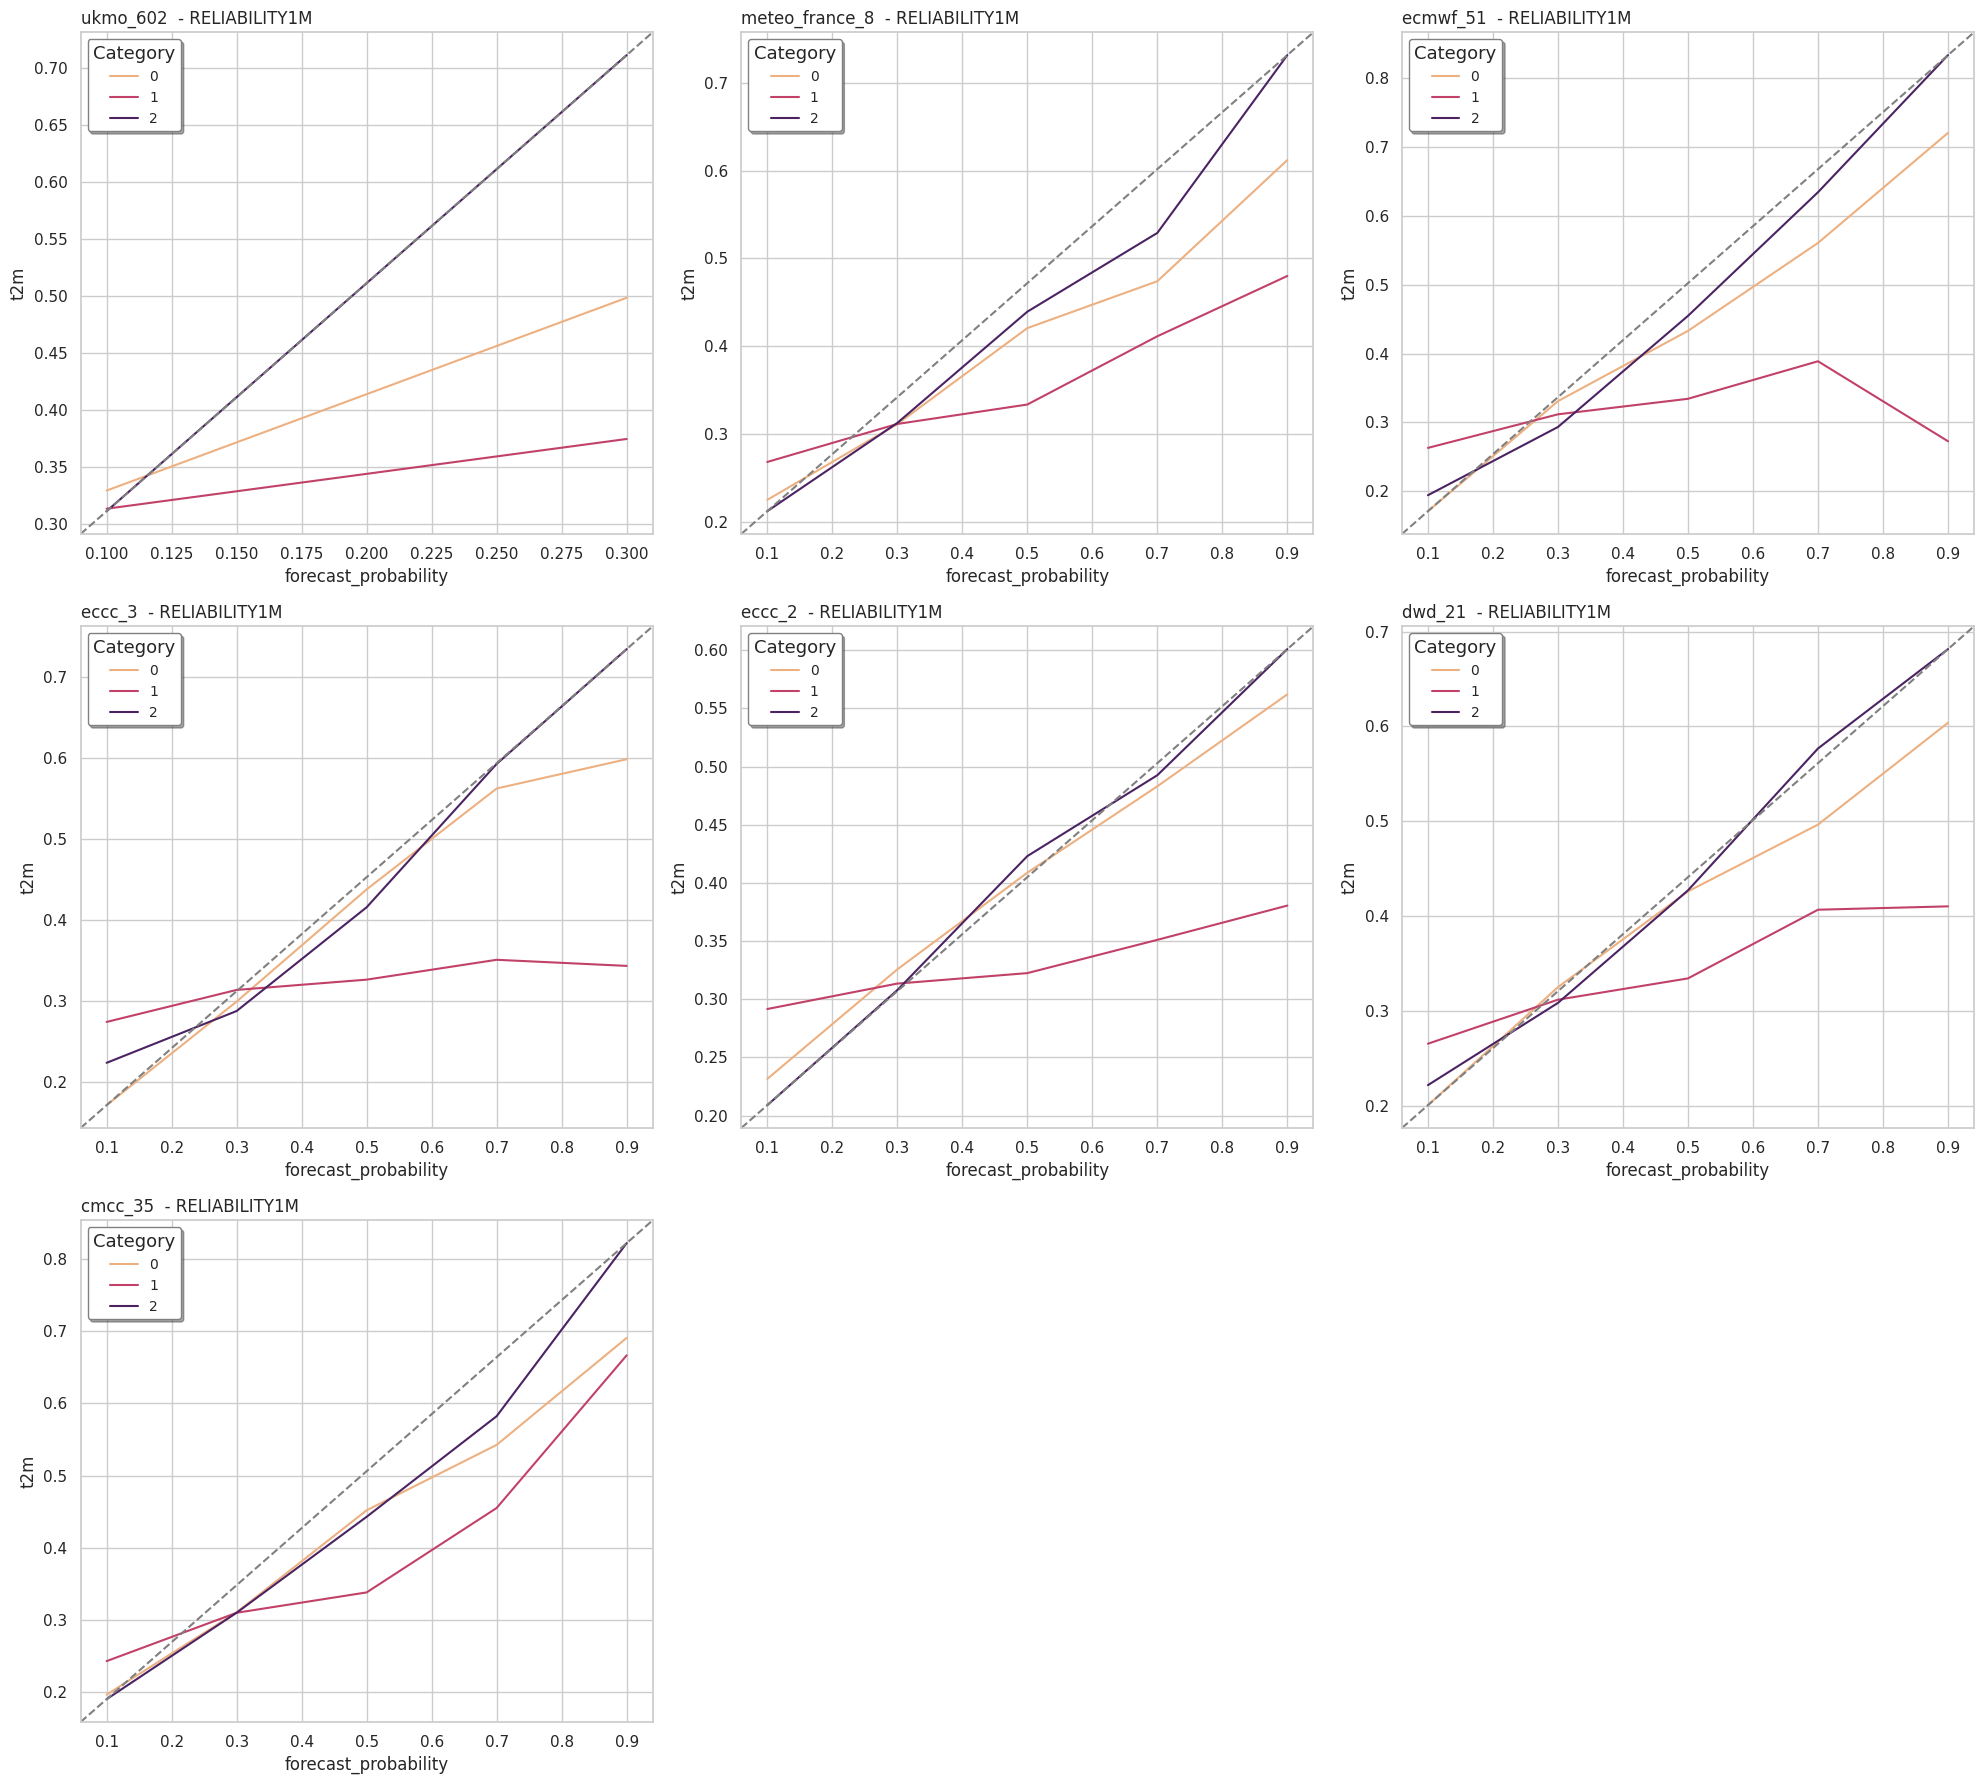

In [37]:
def plot_rela(aggr):
    
    n_files = len(available_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols

    # Create the figure and axes only once
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = axes.flatten()

    for i in range(n_files):
        center = available_files[i]

        # Open the dataset
        rela = xr.open_dataset(f'{SCOREDIR}/{center}{details}.{aggr}.rela.nc')
        
        # Calculate the mean and convert to dataframe
        df = rela.mean(dim=["lon", "lat", "forecastMonth"], skipna=True).to_dataframe().reset_index()

        # df["lead_time"] = df["category"].map({0: "December", 1: "January", 2: "February"})

        thisrela = df
        origin_labels = {"institution": center}
        
        tit_line1 = '{institution} '.format(**origin_labels)
        tit_line2_base = 'RELIABILITY'

        # Set the aggregation title based on the selection
        if aggr == '1m':
            tit_line2 = tit_line2_base + '1M'
        elif aggr == '3m':
            tit_line2 = tit_line2_base + '3M'
        else:
            raise ValueError(f'Unexpected aggregation {aggr}')

        # Plot on the corresponding axis
        sns.lineplot(data=thisrela, x="forecast_probability",palette="flare", y="t2m", hue="category", ax=axes[i])
        sns.set_theme(style="whitegrid")  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
        sns.set_context("notebook")  # Options: 'paper', 'notebook', 'talk', 'poster'
# Blues , Greens , Reds , 

        # Add diagonal line for reference
        axes[i].plot([0, 1], [0, 1], transform=axes[i].transAxes, color='gray', linestyle='--')

        # Set the title for each plot
        axes[i].set_title(f'{tit_line1} - {tit_line2}', loc='left')


        axes[i].legend(
            title="Category",   # Legend title
            title_fontsize='13', # Legend title font size
            loc='upper left',   # Position of the legend
            fontsize='10',      # Font size of legend labels
            frameon=True,       # Add a frame around the legend
            shadow=True,        # Optional shadow
            facecolor='white',  # Background color of the legend box
            edgecolor='gray'    # Border color
        )

    # Remove any unused axes if there are fewer files than available axes
    for j in range(n_files, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout and display the plot only once
    plt.tight_layout()
    plt.show()

# Define the dropdown widget for selecting aggregation
aggr_droptown = widgets.Dropdown(options=["1m", "3m"], value="1m", description="aggr")

# Create an interactive plot
widgets.interactive(plot_rela, aggr=aggr_droptown)


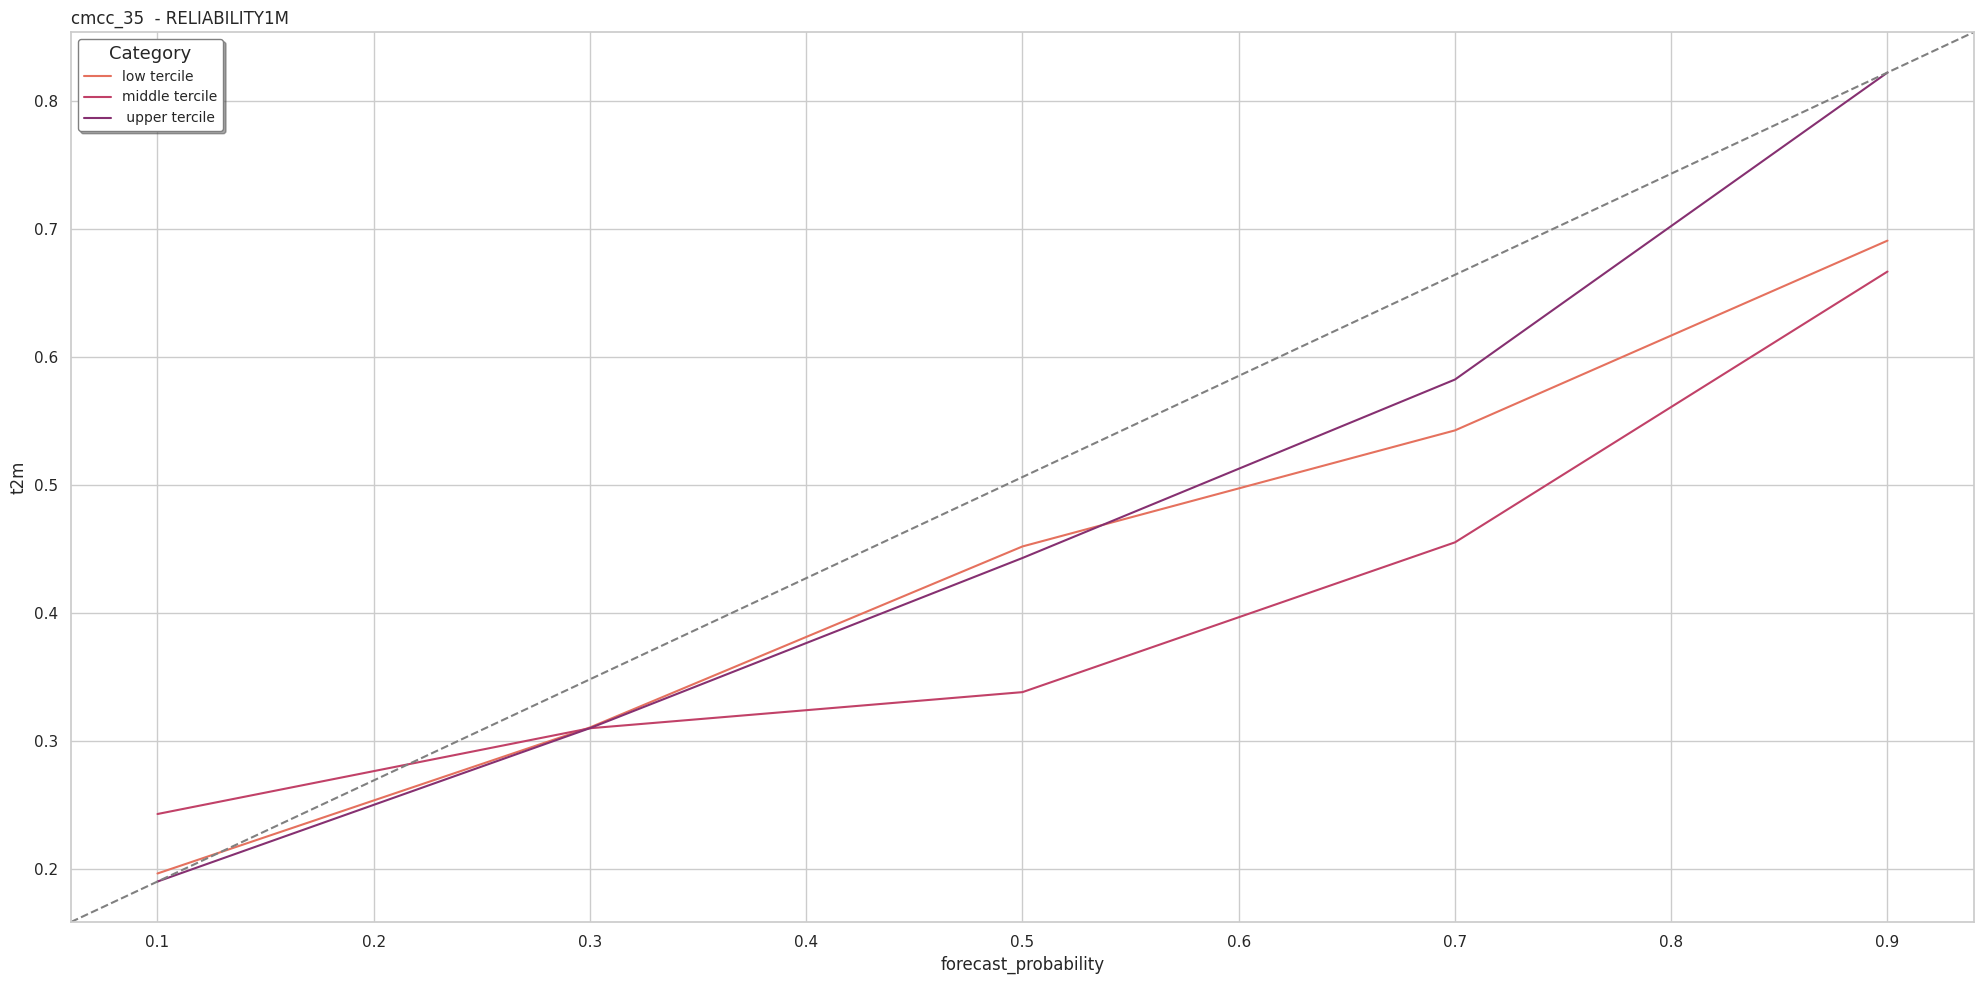

In [38]:
def plot_rela(center,aggr):
    
    n_files = len(available_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols

    # Create the figure and axes only once
    fig, axes = plt.subplots(figsize=(20, 10 ))

    # Open the dataset
    rela = xr.open_dataset(f'{SCOREDIR}/{center}{details}.{aggr}.rela.nc')
    
    # Calculate the mean and convert to dataframe
    df = rela.mean(dim=["lon", "lat", "forecastMonth"], skipna=True).to_dataframe().reset_index()

    df["category"] = df["category"].map({0: "low tercile", 1: "middle tercile", 2: " upper tercile"})

    thisrela = df
    origin_labels = {"institution": center}
    
    tit_line1 = '{institution} '.format(**origin_labels)
    tit_line2_base = 'RELIABILITY'

    # Set the aggregation title based on the selection
    if aggr == '1m':
        tit_line2 = tit_line2_base + '1M'
    elif aggr == '3m':
        tit_line2 = tit_line2_base + '3M'
    else:
        raise ValueError(f'Unexpected aggregation {aggr}')

    # Plot on the corresponding axis
    sns.lineplot(data=thisrela, x="forecast_probability",palette="flare", y="t2m", hue="category", ax=axes)
    sns.set_theme(style="whitegrid")  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
    sns.set_context("notebook")  # Options: 'paper', 'notebook', 'talk', 'poster'
# Blues , Greens , Reds , 

    # Add diagonal line for reference
    axes.plot([0, 1], [0, 1], transform=axes.transAxes, color='gray', linestyle='--')

    # Set the title for each plot
    axes.set_title(f'{tit_line1} - {tit_line2}', loc='left')


    axes.legend(
        title="Category",   # Legend title
        title_fontsize='13', # Legend title font size
        loc='upper left',   # Position of the legend
        fontsize='10',      # Font size of legend labels
        frameon=True,       # Add a frame around the legend
        shadow=True,        # Optional shadow
        facecolor='white',  # Background color of the legend box
        edgecolor='gray'    # Border color
    )

    plt.tight_layout()
    plt.show()

# Define the dropdown widget for selecting aggregation
aggr_droptown = widgets.Dropdown(options=["1m", "3m"], value="1m", description="aggr")
file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")

# Create an interactive plot
widgets.interactive(plot_rela, aggr=aggr_droptown,center=file_droptown)
